In [150]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.spatial import distance
import random as rand
import ast
from sklearn.linear_model import LogisticRegression

In [151]:
with open("diplomacy_data.json", "r") as file:
    diplomacy = json.load(file)
old_data = pd.DataFrame(diplomacy)
data = pd.read_csv("final_data.csv")

In [152]:
betrayals = old_data[old_data['betrayal']==True]['seasons']
lasting = old_data[old_data['betrayal']==False]['seasons']

In [153]:
def message_politeness(messages):
    """return the average politeness score for a particular player in a season"""
    if len(messages)!=0:
        return sum(m['politeness'] for m in messages)/len(messages)
    else:
        return 0

def message_sentiment(messages):
    """return positive sentiment average per sentence"""
    if len(messages)!=0:
        return sum(m['sentiment']['positive']/m['n_sentences'] if m['n_sentences']!=0 else 0  for m in messages)/len(messages)
    else:
        return 0

def message_discourse(messages):
    """return the average number of discourse markers per sentence"""
    n_sents = sum(m['n_sentences'] for m in messages) * 1.0
    if n_sents !=0:
        return sum(len(m['lexicon_words'].get("disc_temporal_future", [])) for m in messages) / n_sents
    else :
        return 0

In [154]:
def extract_stats(player, relation):
    pol, disc, sent = [],[],[]
    for season in relation:
        messages = season['messages'][player]
        pol.append(message_politeness(messages))
        sent.append(message_sentiment(messages))
        disc.append(message_discourse(messages))
    pol = np.mean(np.array(pol))
    disc = np.mean(np.array(disc))
    sent = np.mean(np.array(sent))         
    return pol, disc, sent                   

In [155]:
def extract_stats_season(player, season):
    messages = season['messages'][player]
    return message_politeness(messages),message_sentiment(messages),message_discourse(messages)

In [156]:
def extract_old_seasons(betrayal, data):
    idx, b, length, pol_v, pol_b, disc_v, disc_b, sent_v, sent_b = [],[],[],[],[],[],[],[],[]
    index = data.index
    i = 0
    for rel in data:
        for season in rel:
            idx.append(index[i])
            b.append(betrayal)
            length.append(len(rel))
            pol_v_temp, disc_v_temp, sent_v_temp = extract_stats_season('victim', season)
            pol_b_temp, disc_b_temp, sent_b_temp = extract_stats_season('betrayer', season)
            pol_v.append(pol_v_temp)
            pol_b.append(pol_b_temp)
            disc_v.append(disc_v_temp)
            disc_b.append(disc_b_temp)
            sent_v.append(sent_v_temp)
            sent_b.append(sent_b_temp)
        i +=1
    old_seasons = pd.DataFrame({'ID':idx,'Length':length, 'Politeness victim':pol_v,'Politeness betrayer':pol_b,
                                'Discourse victim': disc_v, 'Discourse betrayer':disc_b, 'Sentiment victim':sent_v, 
                                'Sentiment betrayer': sent_b, 'Betrayal': b})
    return old_seasons

In [157]:
def extract_old_data(betrayal, data):
    idx, b, length, pol_v, pol_b, disc_v, disc_b, sent_v, sent_b = [],[],[],[],[],[],[],[],[]
    index = data.index
    i = 0
    for rel in data:
        idx.append(index[i])
        i +=1
        b.append(betrayal)
        length.append(len(rel))
        pol_v_temp, disc_v_temp, sent_v_temp = extract_stats('victim', rel)
        pol_b_temp, disc_b_temp, sent_b_temp = extract_stats('betrayer', rel)
        pol_v.append(pol_v_temp)
        pol_b.append(pol_b_temp)
        disc_v.append(disc_v_temp)
        disc_b.append(disc_b_temp)
        sent_v.append(sent_v_temp)
        sent_b.append(sent_b_temp)
    new_old_data = pd.DataFrame({'ID':idx,'Length':length, 'Politeness victim':pol_v,'Politeness betrayer':pol_b,
                                'Discourse victim': disc_v, 'Discourse betrayer':disc_b, 'Sentiment victim':sent_v, 
                                'Sentiment betrayer': sent_b, 'Betrayal': b})
    return new_old_data

In [158]:
new_betrayals = extract_old_data(True, betrayals)
new_lasting = extract_old_data(False, lasting)
new_old_data = pd.concat([new_betrayals, new_lasting], ignore_index = True)
new_old_data.head()

,ID,Length,Politeness victim,Politeness betrayer,Discourse victim,Discourse betrayer,Sentiment victim,Sentiment betrayer,Betrayal
0,0,8,0.635394,0.775357,0.096784,0.115962,0.148072,0.211070,True
1,5,10,0.666831,0.746529,0.216604,0.076771,0.214007,0.260434,True
2,8,5,0.338930,0.592231,0.066667,0.173333,0.266667,0.216667,True
3,9,6,0.452057,0.398960,0.083333,0.000000,0.000000,0.125000,True
4,10,3,0.598370,0.608430,0.033333,0.108333,0.155556,0.125000,True


In [159]:
data['sentiment'].fillna('[]',inplace = True )
data["sentiment"] = [ast.literal_eval(data["sentiment"][i]) for i in range(data.shape[0])]
data["nb_sentences"] = [len(data["sentiment"][i]) for i in range(data.shape[0])]
data = data[data["nb_sentences"]>0]

In [160]:
data["discourse_score"] = data["discourse_number"]/data["nb_sentences"]
data["sentiment_score"] = [data["sentiment"][i].count(1)/data["nb_sentences"][i] for i in data.index]

In [161]:
def extract_new_data(data):
    rand.seed(8)
    idx, length, pol_v, pol_b, disc_v, disc_b, sent_v, sent_b = [],[],[],[],[],[],[],[]
    for r in set(data["conversation_id"]):
        rel = data[data["conversation_id"] == r]
        players = list(set(rel["speaker"]))
        if len(players) == 2 :
            idx.append(r)
            length.append(2*(rel["meta.year"].max()-rel["meta.year"].min())+1)
            if rand.random() < 0.5 :
                v = players[0]
                b = players[1]
            else :
                v = players[1]
                b = players[0]
            pol_v.append(rel[rel["speaker"]==v]["meta.pred_score"].mean())
            pol_b.append(rel[rel["speaker"]==b]["meta.pred_score"].mean())
            disc_v.append(rel[rel["speaker"]==v]["discourse_score"].mean())
            disc_b.append(rel[rel["speaker"]==b]["discourse_score"].mean())
            sent_v.append(rel[rel["speaker"]==v]["sentiment_score"].mean()) 
            sent_b.append(rel[rel["speaker"]==b]["sentiment_score"].mean())
    new_data = pd.DataFrame({'ID':idx,'Length':length, 'Politeness victim':pol_v,'Politeness betrayer':pol_b,
                                'Discourse victim': disc_v, 'Discourse betrayer':disc_b, 'Sentiment victim':sent_v, 
                                'Sentiment betrayer': sent_b})
    return new_data

In [162]:
new_data = extract_new_data(data)
new_data.head()

,ID,Length,Politeness victim,Politeness betrayer,Discourse victim,Discourse betrayer,Sentiment victim,Sentiment betrayer
0,Game1-germany-france,13,0.470638,0.473501,0.208497,0.269531,0.137217,0.199870
1,Game2-austria-germany,15,0.369422,0.304586,0.098281,0.116537,0.120329,0.100000
2,Game8-turkey-italy,7,0.449544,0.389881,0.202525,0.130303,0.113636,0.129275
3,Game7-austria-germany,19,0.366159,0.442090,0.230392,0.261905,0.102941,0.178571
4,Game5-turkey-england,19,0.395564,0.401266,0.166667,0.197059,0.133333,0.188235


In [131]:
#Matching
#"Discourse victim", "Discourse betrayer", "Sentiment victim", "Sentiment betrayer"
def find_match(friendship_new, new_old_data, unique_matches, multi_matches):
    f_to_match = np.array(friendship_new[["Length","Politeness victim","Politeness betrayer"]])
    old_to_match = new_old_data[["Length","Politeness victim","Politeness betrayer"]]
    dist = [distance.cosine(f_to_match, np.array(old_to_match.loc[i])) for i in new_old_data.index]
    pot_matches = [i for i in new_old_data.index if dist[i] < 0.0001]#Select errors elow the threshold
    if len(pot_matches) == 0: #If no match found, print error and exit function
        print('No match found for', friendship_new['ID'])
        return [(friendship_new['ID'], 'NaN'),(friendship_new['ID'], 'NaN')]
    else: #If at least one potential match is found :
        dist_multi = dist.copy()
        for m in pot_matches :
            if new_old_data['ID'][m] in unique_matches.values():
                pot_matches.remove(m) 
                dist.remove(dist_multi[m])
        if len(pot_matches) == 0: 
            print('No unique match found for', friendship_new['ID'])
            best_match_unique = 'Nan'
        else :
            min_index_unique = np.squeeze(np.where(dist == np.min(dist)))
            best_match_unique = new_old_data['ID'][min_index_unique]
        min_index_multi = np.squeeze(np.where(dist_multi == np.min(dist_multi)))   
        best_match_multi = new_old_data['ID'][min_index_multi]
           
        return [(friendship_new['ID'], best_match_unique), (friendship_new['ID'], best_match_multi)]

In [132]:
unique_matches = dict()
multi_matches = dict()

for i in new_data.index :
    [(new, unique_old),(new, multi_old)] = find_match(new_data.loc[i], new_old_data, unique_matches, multi_matches)
    unique_matches[new] = unique_old
    multi_matches[new] = multi_old

No match found for Game1-germany-france
No match found for Game12-england-germany
No match found for Game3-turkey-italy
No match found for Game4-italy-russia
No match found for Game10-england-austria
No match found for Game7-germany-russia
No match found for Game10-turkey-italy
No match found for Game9-france-russia
No match found for Game2-france-russia
No match found for Game9-germany-russia
No match found for Game7-england-germany
No match found for Game3-austria-russia
No match found for Game3-turkey-england
No match found for Game6-austria-germany
No match found for Game11-austria-russia
No match found for Game11-germany-italy
No match found for Game7-england-france
No match found for Game8-germany-france
No match found for Game9-austria-france
No match found for Game3-italy-germany
No match found for Game2-england-russia
No match found for Game4-austria-italy
No unique match found for Game6-england-germany
No match found for Game9-germany-france
No match found for Game11-austria-

In [133]:
unique_df = pd.DataFrame({"New relationship":unique_matches.keys(), "Old relationship": unique_matches.values()})
unique_matches_df = unique_df[unique_df["Old relationship"] != 'NaN']
multi_df = pd.DataFrame({"New relationship":multi_matches.keys(), "Old relationship": multi_matches.values()})
multi_matches_df = multi_df[multi_df["Old relationship"] != 'NaN']
print("Unique matches:", unique_matches_df.shape[0], "Multi matches:", multi_matches_df.shape[0])
print("Relationships in the new dataset :", new_data.shape[0])
unique_matches_df.head()

Unique matches: 56 Multi matches: 56
Relationships in the new dataset : 238


,New relationship,Old relationship
1,Game2-austria-germany,11
2,Game8-turkey-italy,47
3,Game7-austria-germany,332
4,Game5-turkey-england,373
8,Game6-england-france,330


In [146]:
X_train = new_old_data[["Length","Politeness victim","Politeness betrayer", 
                        "Discourse victim", "Discourse betrayer", "Sentiment victim", "Sentiment betrayer"]]
y_train = new_old_data["Betrayal"]

In [145]:
import statsmodels.api as sm
log_reg = sm.Logit(y_train, sm.add_constant(X_train)).fit_regularized(method="l1")
log_reg.summary()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6844879673885708
            Iterations: 54
            Function evaluations: 55
            Gradient evaluations: 54


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Betrayal   No. Observations:                  500
Model:                          Logit   Df Residuals:                      492
Method:                           MLE   Df Model:                            7
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                 0.01249
Time:                        15:30:30   Log-Likelihood:                -342.24
converged:                       True   LL-Null:                       -346.57
Covariance Type:            nonrobust   LLR p-value:                    0.2781
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0858      0.298     -0.288      0.774      -0.670       0.499
Length                  0.0116      0.038      0.306      0.759      -0.062       0.085
Politeness victim      -1.1886      0.675     -1.761      0.078      -2.512       0.135
Politeness betrayer     0.1725      0.744      0.232      0.817      -1.285       1.630
Discourse victim        1.1397      1.760      0.648      0.517      -2.310       4.589
Discourse betrayer     -1.8042      2.052     -0.879      0.379      -5.827       2.218
Sentiment victim        1.4418      1.469      0.982      0.326      -1.437       4.320
Sentiment betrayer      2.7494      1.412      1.947      0.052      -0.018       5.517
=======================================================================================
"""

In [170]:
old_seasons_b = extract_old_seasons(True, betrayals)
old_seasons_l = extract_old_seasons(False, lasting)
old_seasons = pd.concat([old_seasons_b, old_seasons_l], ignore_index = True)
old_seasons.shape

(3294, 9)

In [236]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [266]:
from sklearn.metrics import matthews_corrcoef
k_fold = 5
acc = []
matt = []
y = old_seasons["Betrayal"]
features= ["Politeness victim","Politeness betrayer", "Discourse victim", "Discourse betrayer", 
           "Sentiment victim", "Sentiment betrayer"]
x = old_seasons[features] 
seed = 15
k_indices = build_k_indices(y, k_fold, seed)
for k in range(k_fold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x.loc[te_indice]
    x_te["const"] = [1 for i in range(x_te.shape[0])]
    x_tr = x.loc[tr_indice]
    log_reg = sm.Logit(y_tr, sm.add_constant(x_tr)).fit_regularized(method="l1")
    predictions = log_reg.predict(x_te)
    print(log_reg.summary())
    results = []
    for i in predictions.index:
        if predictions[i] < 0.5 :
            results.append(False)
        else :
            results.append(True)
    acc.append(np.where(y_val == results)[0].shape[0]/len(results))
    results = np.array(results)
    y_true = np.where(y_val == True, 1, 0)
    y_test = np.where(results == True, 1, 0)
    matt.append(matthews_corrcoef(y_true, y_test))
avg_acc = np.mean(np.array(acc))
avg_matt = np.mean(np.array(matt))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.690310636346425
            Iterations: 54
            Function evaluations: 54
            Gradient evaluations: 54
                           Logit Regression Results                           
Dep. Variable:               Betrayal   No. Observations:                 2632
Model:                          Logit   Df Residuals:                     2625
Method:                           MLE   Df Model:                            6
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                0.003999
Time:                        17:32:50   Log-Likelihood:                -1816.9
converged:                       True   LL-Null:                       -1824.2
Covariance Type:            nonrobust   LLR p-value:                   0.02370
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

C:\Users\clara\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\clara\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [267]:
print("Accuracy:", avg_acc, "Matthews:", avg_matt)

Accuracy: 0.5006079027355623 Matthews: 0.00531527330776098


In [219]:
lies = data[data["meta.speaker_intention"] == 'Lie']
truths = data[data["meta.speaker_intention"] == 'Truth']
print("Number of intended lies :", lies.shape[0])
print("Number of intended truths :", truths.shape[0])

Number of intended lies : 882
Number of intended truths : 16354


In [220]:
coolors = {"Black":[12/256,15/256,10/256],
 "Green":[21/256,113/256,69/256], #dark green
 "Emerald":[90/256,200/256,120/256], #light green
 "Red":[256/256,60/256,50/256], #light red
 "Burgundy":[165/256,36/256,61/256]} #dark red

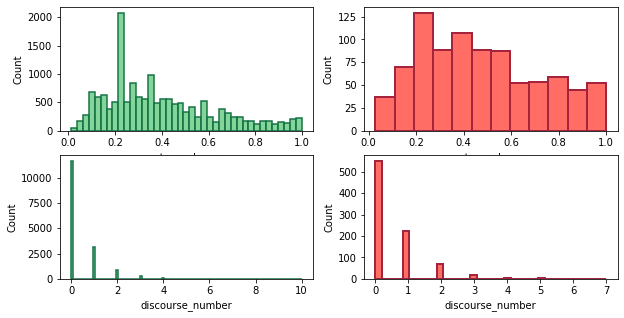

In [30]:
colors = {'Lie' : coolors["Red"], 'Truth': coolors["Emerald"]}
fig, axs = plt.subplots(2,2, figsize = (10,5))
sns.histplot(data = truths, x = "meta.pred_score", ax = axs[0,0], color = colors['Truth'], 
             edgecolor=coolors['Green'], linewidth=1.5)
sns.histplot(data = lies, x = "meta.pred_score", ax = axs[0,1], color=colors['Lie'], 
             edgecolor = coolors['Burgundy'], linewidth=2)
sns.histplot(data = truths, x = "discourse_number", ax = axs[1,0], color = colors['Truth'], 
             edgecolor=coolors['Green'], linewidth=1.5)
sns.histplot(data = lies, x = "discourse_number", ax = axs[1,1], color=colors['Lie'], 
             edgecolor = coolors['Burgundy'], linewidth=2)

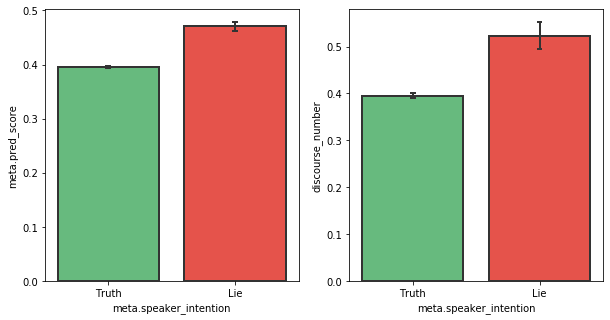

In [29]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = data, y = "meta.pred_score", x = "meta.speaker_intention", ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors, ax = axs[0])
sns.barplot(data = data, y = "discourse_number", x = "meta.speaker_intention", ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors, ax = axs[1])

to do :
- replotter les 3 figures du paper (Fig3 a, b, c)
- matching avec les relations de l'ancien dataset
